# Introdução

- Nova abordagem numérica para resolver EDP utilizando Redes Neurais
- Referências
    - **Códigos em Python e artigo da versão 2.X do tensorflow para criação da rede neural:** BLECHSCHMIDT, J. Links: [Código](https://github.com/janblechschmidt/PDEsByNNs); [Artigo](https://arxiv.org/abs/2102.11802). (2021)

    - **Artigo biblioteca DeepXDE:** LU, L. et al. DeepXDE: A Deep Learning Library for Solving Differential Equations. Links: [Artigo - arxiv](https://arxiv.org/abs/1907.04502); [Artigo - SIAM](https://epubs.siam.org/doi/10.1137/19M1274067); [Código](https://github.com/lululxvi/deepxde) (2021)

    - **Raissi et al:** RAISSI, M.; KARNIADAKIS, G. E.;PERDIKARIS, P.; [Códigos (1.X TensorFlow)](https://github.com/maziarraissi/PINNs>); [Artigo 1](https://arxiv.org/abs/1708.00588); [Artigo 2](https://arxiv.org/abs/1711.10561); [Artigo 3](https://arxiv.org/abs/1711.10566); [Artigo 4](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125) (2017 - 2019)


- Redes Neurais tem suas vantagens e desvantagens

    **Vantagens**
    - [Teoria da Aproximação Universal](https://drive.google.com/file/d/1xfE2Bx9NbVeNU_mseTpIaYO0wIQZbbXb/view?usp=drive_link)
    - Incorporação da física da EDP
    - Fácil implementação e eficiencia computacional

    Desvantagens
    - Alto Custo Computacional
    - Como a rede achou a solução?
    - Dependência de Dados de Treinamento

# Transformação do problema de interesse em um problema de Otimização

## Descrição da Equação de Burgers Viscosa
A Equação Diferencial Parcial que trataremos consiste em determinar $u = u(x,t)$ solução de:
\begin{aligned}
    u_t + u \, u_x - \nu \, u_{xx} &= 0, \quad &&\quad (x,t) \in  (-1,1) \times (0,1) \\
   u(x,0) &= u_0(x),                 \quad &&\quad x \in (-1,1),\\
   u(-1,t) = u(1,t) &= 0,                      \quad &&\quad t \in (0,1),
\end{aligned}

onde $\nu$ é a viscosidade. Esta EDP surge em diferentes contextos, por exemplo, tráfego de carros, dinâmica dos fluidos.

# Modelagem Computacional: [Equação de Burgers Viscosa]( https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html#burgers-equation)

O tratamento numérico da Equação de Burgers Viscosa será feito por meio de uma formulação computacional que consiste em transformar o problema de valor inicial e de fronteira em um problema de otimização.

Mais especificamente, vamos determinar uma função $u(x,t)$ que resolve simultaneamente os seguintes problemas de otimização:

1. Operador Diferencial: $$\min |f(x,t)| \quad \text{ s.a. } \quad (x,t) \in  (-1,1) \times (0,1),$$ onde $f:= u_t + uu_x - \nu u_{xx}$
2. Condição Inicial: $$\min |u(x,0) - u_0(x)| \quad \text{ s.a. } \quad x \in  (-1,1)$$
3. Condição de Fronteira/Bordo: $$\min |u(-1,t)| + |u(1,t)| \quad \text{ s.a. } \quad t \in  (0,1).$$

A função $u(x,t)$ será aproximada via Redes Neurais por meio da minimização do Erro Médio Quadrático (EMQ) da função de perda.

Neste contexto os Problemas 1, 2 e 3 acima são reescritos da seguinte forma:

1. $\text{EMQ}_f = \cfrac{1}{N_f}\sum_{i = 1}^{N_f} \left| f(x_i, t_i) \right|^2,$ onde $(x_i, t_i)$, $i = 1, \cdots, N_f$, representa $N_f$ pontos de colocação escolhidos aleatoriamente em $(-1,1) \times (0,1)$.

2. $\text{EMQ}_0 = \cfrac{1}{N_0}\sum_{i=1}^{N_0} \left| (u(x_i,0) - u_0(x_i)\right|^2,$ onde $x_i$, $i = 1, \cdots, N_0$ representa $N_0$ pontos de colocação no intervalo $(-1,1)$;

3. $\text{EMQ}_b = \cfrac{1}{N_b}\sum_{i=1}^{N_b} \left| u(x_i,t_i) \right|^2$, onde $(x_i,t_i)$, $i = 1, \cdots, N_b$ corresponde à $N_b$ pontos de colocação ao longo do conjunto cartesiano $\{-1,1\} \times (0,1)$.

Por fim, minimizamos e função de perda:
$$\text{EMQ} = \text{EMQ}_f + \text{EMQ}_0 + \text{EMQ}_b$$

Iremos utilizar a biblioteca em Python [**DeepXDE**](https://deepxde.readthedocs.io/en/latest/index.html). Baseando-se nas referências, utilizaremos e EDP de Burguers Viscosa, ou seja, a EDP que trataremos consiste em determinar $u = u(x,t)$ solução de:

## Passo a passo do código

Dado a EDP:

$$
\begin{aligned}
    u_t + u \, u_x - \nu \, u_{xx} &= 0, \quad &&\quad (x,t) \in  (-1,1) \times (0,1) \\
   u(x,0) &= -\sin(\pi x),                 \quad &&\quad x \in (-1,1),\\
   u(-1,t) = u(1,t) &= 0,                      \quad &&\quad t \in (0,1),
\end{aligned}
$$




Primeiro, importaremos as bibliotecas DeepXDE e TensorFlow:

In [ ]:
!pip install deepxde -q   # -q para ele instalar sem as mensagens, retirar o -q para verificar o que instalou
import os

os.environ['DDE_BACKEND'] = 'tensorflow'  # existem outras opções, como tensorflow.compat.v1, pytorch, jax, paddle.

import deepxde as dde
import numpy as np
import tensorflow as tf

'''
Essa biblioteca tem como dependencias:
como o matplotlib, numpy, scikit-learn, scikit-optimize, SciPy
'''

# deixar a semente aleatória fixa
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
dde.config.set_random_seed(seed_value)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.6 MB/s eta 0:00:00


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Começamos definindo uma geometria computacional e um domínio de tempo. Podemos usar uma classe interna `Interval` e `TimeDomain` e combinar ambos os domínios usando `GeometryXTime` da seguinte forma:

In [ ]:
# Definição da geometria espacial
geom = dde.geometry.Interval(-1, 1)  # Define um intervalo para x, coordenada espacial, no intervalo (-1, 1)
# Definição do domínio temporal
timedomain = dde.geometry.TimeDomain(0, 1)  # Define um domínio de tempo para t, coordenada temporal, no intervalo (0, 1)

# Combinando a geometria espacial e o domínio temporal
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  # Combina a geometria espacial e o domínio temporal em uma geometria espacial-temporal

A seguir, expressamos o resíduo EDP da equação de Burgers Viscosa:

In [ ]:
def pde(x, y):
    # x = (x, t) representa as coordenadas espaciais (x) e temporais (t)
    # y = u(x, t) representa a solução da equação de Burgers viscosa no ponto (x, t)

    # Calculando a primeira derivada em relação à coordenada espacial (x)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)

    # Calculando a primeira derivada em relação à coordenada temporal (t)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)

    # Calculando a segunda derivada em relação à coordenada espacial (x)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)

    '''
    Definindo a equação diferencial parcial (EDP) de Burgers viscosa
    A equação é: u_t + u*u_x - nu*u_xx = 0
    Onde u_t representa a derivada parcial de u em relação ao tempo (t)
    u*u_x representa o produto de u e sua derivada parcial em relação à coordenada espacial (x)
    nu*u_xx representa a segunda derivada de u em relação à coordenada espacial (x)
    nu é o coeficiente de viscosidade, que nesse exemplo nu = 0.01/pi
    '''
    # Retorna a equação diferencial parcial de Burgers viscosa
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


A seguir, consideramos a condição de contorno/inicial. ``on_boundary`` é escolhido aqui para usar todo o limite do domínio computacional considerado como a condição de limite. Incluímos o espaço ``geomtime``, a geometria do tempo criada acima e ``on_boundary`` como os ``BCs`` na função ``DirichletBC`` do ``DeepXDE``. Também definimos ``IC``, que é a condição inicial para a equação de Burgers Viscosa, e usamos o domínio computacional, a função inicial e ``on_initial`` para especificar o IC.

In [ ]:
'''
Definição da condição de contorno (BC) para a equação de Burgers viscosa
Utilizamos "on_boundary" para especificar que todas as bordas do domínio são consideradas condições de contorno, em alguns casos definimos
boundary_left e/ou boundary_right para condições diferentes a esquerda e a direita
A função lambda define a condição de contorno como zero para todas as bordas do domínio
'''
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

'''
Definição da condição inicial (IC) para a equação de Burgers viscosa
Utilizamos "on_initial" para especificar que a condição inicial é aplicada no início do domínio temporal
A função lambda define a condição inicial como -sin(pi*x) para todas as posições iniciais (x) no domínio
'''
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)


Agora, especificamos a geometria, o resíduo da EDP e a condição de contorno/inicial. Definimos então o problema ``TimePDE`` como:

In [ ]:
# Criação dos dados para treinamento do modelo
'''
    geomtime: geometria espacial + temporal
    pde: definição da edp que queremos a solução
    [bc,ic]: lista com as condições de borda e inicial definidas
    num_domain: número de pontos amostrados dentro do domínio
    num_boundary: número de pontos amostrados na borda
    num_initial: número de pontos amostrados na condição inicial
'''
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=3000, num_boundary=150, num_initial=150)


O número 2540 é o número de pontos residuais de treinamento amostrados dentro do domínio e o número 80 é o número de pontos de treinamento amostrados na fronteira. Também incluímos 160 pontos residuais iniciais para as condições iniciais.

A seguir, escolhemos e montamos a arquitetura da rede. Aqui, usamos uma rede neural totalmente conectada de profundidade 4 (ou seja, 3 camadas ocultas) e 20 neurônios:

In [ ]:
'''
    [2]: camada de entrada, 2 entradas, espaço e tempo
    [20]*3: 3 camadas com 20 neurônios
    tanh: função de ativação
    glorot normal: inicializador de pesos
'''
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

Agora temos o problema da EDP e a rede. Construímos um modelo e escolhemos o otimizador e a taxa de aprendizagem:

In [ ]:
model = dde.Model(data, net) # criação do modelo com data os dados, e net a Rede Neural
model.compile("adam", lr=1e-3) # compilação do modelo utilizando o otimizador ADAM, com taxa de aprendizagem lr = 1e-3

Compiling model...
'compile' took 0.019479 s



Em seguida, treinamos o modelo para 10.000 iterações:

In [ ]:
'''
    losshistory: lista que armazena o histórico de valores da perda.
    train_state: informações do treinamento, como iterações, tempo
'''
losshistory, train_state = model.train(iterations=10000)

Training model...



/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Cause: could not parse the source code of <function <lambda> at 0x7c9ba87ffe20>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7c9ba87ffe20>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7c9b11474ca0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7c9b11474ca0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                        Test loss                         Test metric
0         [2.97e-01, 1.15e-01, 4.31e-01]    [2.97e-01, 1.15e-01, 4.31e-01]    []  
1000      [4.27e-02, 1.62e-03, 5.81e-02]    [4.27e-02, 1.62e-03, 5.81e-02]    []  
2000      [3.40e-02, 3.18e-04, 4.47e-02]    [3.40e-02, 3.18e-04, 4.47e-02]    []  
3000      [1.65e-02, 1.09e-04, 1.28e-02]    [1.65e-02, 1.09e-04, 1.28e-02]    []  
4000      [8.32e-03, 2.58e-05, 4.37e-03]    [8.32e-03, 2.58e-05, 4.37e-03]    []  
5000      [5.60e-03, 1.65e-05, 2.90e-03]    [5.60e-03, 1.65e-05, 2.90e-03]    []  
6000      [4.20e-03, 1.52e-05, 2.37e-03]    [4.20e-03, 1.52e-05, 2.37e-03]    []  
7000      [3.34e-03, 1.49

Depois de treinarmos a rede usando ADAM, continuamos a treinar a rede usando L-BFGS para obter uma perda menor:

In [ ]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.006147 s

Training model...

10000     [7.54e-05, 2.62e-07, 4.05e-05]    [7.54e-05, 2.62e-07, 4.05e-05]    []  
10077     [7.17e-05, 2.42e-07, 3.78e-05]    [7.17e-05, 2.42e-07, 3.78e-05]    []  

Best model at step 10077:
  train loss: 1.10e-04
  test loss: 1.10e-04
  test metric: []

'train' took 30.497544 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


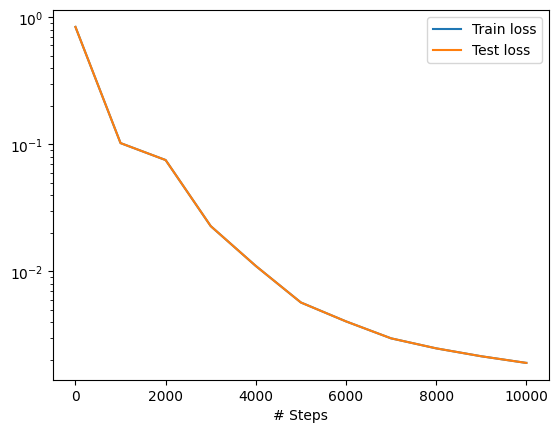

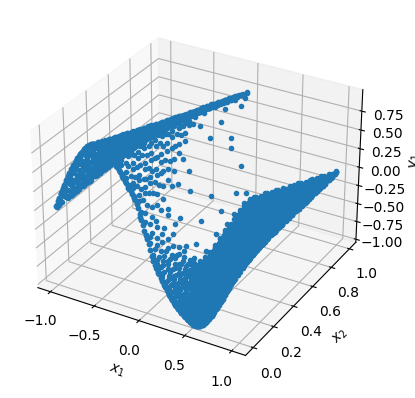

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
def gen_testdata():
    # Carrega os dados do arquivo "Burgers.npz" disponível no github do Lu Lu
    data = np.load("Burgers.npz")
    # Extrai os valores de tempo (t), posição (x) e solução exata (usol)
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Cria uma grade bidimensional de coordenadas (x, t)
    xx, tt = np.meshgrid(x, t)
    # Transforma as grades em vetores unidimensionais e empilha-os lado a lado
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    # Transforma a solução exata em um vetor coluna
    y = exact.flatten()[:, None]
    # Retorna as coordenadas (X) e a solução exata (y)
    return X, y

In [ ]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 0.022131935
L2 relative error: 0.03538811446237148


In [ ]:
y_pred

array([[ 5.4571778e-05],
       [ 2.5230352e-02],
       [ 5.0417636e-02],
       ...,
       [-1.0614034e-02],
       [-4.0087663e-03],
       [ 2.6242770e-03]], dtype=float32)

In [ ]:
import scipy.io as sio
y_pred = y_pred.reshape(100,256)
sio.savemat('deepxde.mat', {'y_pred':y_pred})

In [ ]:
import scipy.io

# Load MATLAB file
mat_data = scipy.io.loadmat('burgers_shock.mat')
usol = mat_data['usol']

from numpy import linalg as LA

norma_fru = LA.norm(y_pred.T-usol, "fro") / LA.norm(usol, "fro")
print(f'{norma_fru:10.8e}')

3.53881145e-02
